# Correlate footprints between 10x and Hydropv2

In [1]:
import os
import anndata
import pandas as pd
import crested

import scprinter as scp

2025-08-20 12:52:06.504 | WARNING  | crested.tl:<module>:25 - modiscolite is not installed, 'crested.tl.modisco' module will not be available.
/lustre1/project/stg_00002/mambaforge/vsc35862/envs/scprinter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
zip_folder = "../../../../../../data/hydrop/mcortex/paper_zips"
printer_hydrop_object_path = f"{zip_folder}/10x_hydropv2_comparisons_data/printer/printer_mouse_hydropv2.h5ad"
printer_10x_object_path = f"{zip_folder}/10x_hydropv2_comparisons_data/printer/printer_mouse_10x.h5ad"
barcodegroups_10x_path = f"{zip_folder}/10x_hydropv2_comparisons_data/printer/barcodegroups_mouse_10x.csv"
barcodegroups_hydrop_path = f"{zip_folder}/10x_hydropv2_comparisons_data/printer/barcodegroups_mouse_hydropv2.csv"
biccn_enhancers_path = f"{zip_folder}/10x_hydropv2_comparisons_data/biccn_enhancers.csv"

In [3]:
genome = scp.genome.mm10

In [4]:
printer_hydrop = scp.load_printer(printer_hydrop_object_path, genome)
printer_10x = scp.load_printer(printer_10x_object_path, genome)

In [5]:
barcodegroups_hydrop = pd.read_csv(barcodegroups_hydrop_path, header=0, sep="\t")
barcodegroups_10x = pd.read_csv(barcodegroups_10x_path, header=0, sep="\t")

In [6]:
barcodegroups_hydrop.head(10)

,obs_name,cell_type
0,AACAACCATCCCACGCTATTCTTCACCTTCpart2,Micro_PVM
1,AAGCAGATAGAAGGTGTGGTATCGACCTTGpart2,OPC
2,AAGCAGATAGAAGGTGTGGTGAACACTGGApart2,Pvalb
3,AAGCAGATAGGCTCATCACTGTCTATTCCApart2,L6_CT
4,AAGCAGATAGGGCTCAATACGGTGGATTCApart2,Astro
5,AAGCAGATAGGTAATTGAGGAAGCCGCATApart2,Astro
6,AAGCAGATAGTATCACACGAGAGAGAAGTCpart2,Oligo
7,AAGCAGATAGTCGCCTAAGTGAGGTTAATGpart2,L2_3_IT
8,AAGCAGATAGTTAACAGTCATGGCTTAACApart2,Micro_PVM
9,AAGCAGATAGTTCTTCTGATACCTGAGATGpart2,Astro


In [7]:
barcodegroups_10x["cell_type"] = barcodegroups_10x.cell_type.astype(str)
barcodegroups_10x["obs_name"] = barcodegroups_10x.obs_name.astype(str)

barcodegroups_hydrop["cell_type"] = barcodegroups_hydrop.cell_type.astype(str)
barcodegroups_hydrop["obs_name"] = barcodegroups_hydrop.obs_name.astype(str)

In [8]:
cell_grouping_hydrop, group_names_hydrop = scp.utils.df2cell_grouping(printer_hydrop, barcodegroups_hydrop)
cell_grouping_10x, group_names_10x = scp.utils.df2cell_grouping(printer_10x, barcodegroups_10x)

In [9]:
def convert_region_to_width(region, width: int = 1840):
    start, end = region.split(":")[1].split("-")
    start = int(start)
    end = int(end)
    center = (start + end) // 2
    start = center - width // 2
    end = center + width // 2
    return f"{region.split(':')[0]}:{start}-{end}"

In [14]:
biccn_enhancers = pd.read_csv(biccn_enhancers_path, header=0, sep=",")
biccn_enhancers = biccn_enhancers[biccn_enhancers["species"] == "mouse"]
biccn_enhancers.head(3)

,old_idx,chrom,start,end,name,target_ct,second_target_ct,specificity,strength,enhancerID,species
0,9,chr1,46868072,46868423,chr1:46868072-46868423,L6_IT_Car3,NaN,On-Target,strong,AiE2051m,mouse
1,18,chr1,81508154,81508487,chr1:81508154-81508487,SstChodl,NaN,On-Target,strong,AiE0465m,mouse
2,19,chr1,90560790,90561290,chr1:90560790-90561290,Sncg,NaN,On-Target,strong,AiE0492m,mouse


In [56]:
# fix names
biccn_to_10x_mapping = {
    'Astro': 'Astro',
    'L6b': 'L6b', 
    'Lamp5': 'Lamp5',
    'Oligo': 'Oligo',
    'Pvalb': 'Pvalb',
    'Sst': 'Sst',
    'Endo': 'Endo_VLMC',      
    'L2_3IT': 'L2_3_IT',      
    'L4IT': 'L2_3_IT',        
    'L5ET': 'L5_ET',          
    'L5IT': 'L5_IT',          
    'L5_6NP': 'L5_6_NP',      
    'L6_IT_Car3': 'L6_IT',    
    'Lamp5_Lhx6': 'Lamp5',    
    'Pvalb_Chc': 'Pvalb',     
    'Sncg': 'Sncg_Vip',       
    'SstChodl': 'Sst',        
    'Vip': 'Sncg_Vip'         
}
biccn_enhancers["target_ct"] = biccn_enhancers["target_ct"].map(biccn_to_10x_mapping)

In [19]:
# biccn enhancer regions with their annotations
regions_of_interest_unchanged = biccn_enhancers.name.values 
# regions_of_interest_unchanged = [region[3:] for region in regions_of_interest_unchanged]
regions_of_interest_500 = [convert_region_to_width(region, 500) for region in regions_of_interest_unchanged]

In [58]:
classes_of_interest = list(biccn_enhancers.target_ct.values)

## Get footprints scores

In [23]:
printer_hydrop.load_disp_model()
printer_hydrop.load_bindingscore_model("TF", scp.datasets.pretrained_TFBS_model)
printer_hydrop.load_bindingscore_model("Nuc",scp.datasets.pretrained_NucBS_model)

printer_10x.load_disp_model()
printer_10x.load_bindingscore_model("TF", scp.datasets.pretrained_TFBS_model)
printer_10x.load_bindingscore_model("Nuc",scp.datasets.pretrained_NucBS_model)

In [26]:
# hydrop footprint scores for all classes for regions of interest
import time
import numpy as np

start = time.time()
scp.tl.get_footprint_score(
    printer_hydrop,
    cell_grouping_hydrop,
    group_names_hydrop,
    regions_of_interest_500,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=16,
    save_key="500_footprints",
    backed=False, # leads to corrupted files
    overwrite=True)
print ("takes", time.time()-start)

estimated file size: 0.36 GB
Creating 500_footprints in printer.footprintsadata
obs=groups, var=regions
1000 100
Loading insertion profiles


collecting multi-scale footprints: 100%|██████████| 12078/12078 [02:28<00:00, 81.13it/s] 

takes 586.2131624221802


In [27]:
# 10x footprints
start = time.time()
scp.tl.get_footprint_score(
    printer_10x,
    cell_grouping_10x,
    group_names_10x,
    regions_of_interest_500,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=16,
    save_key="500_footprints",
    backed=False, # leads to corrupted files
    overwrite=True)
print ("takes", time.time()-start)

estimated file size: 0.36 GB
Creating 500_footprints in printer.footprintsadata
obs=groups, var=regions
1000 100
Loading insertion profiles


collecting multi-scale footprints: 100%|██████████| 12078/12078 [02:08<00:00, 93.80it/s] 

takes 492.42281126976013


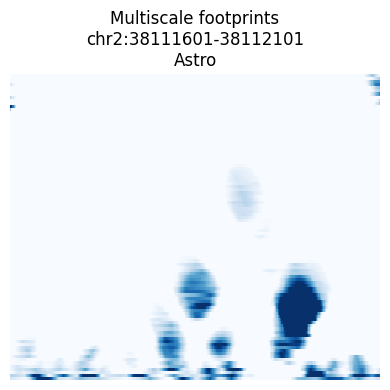

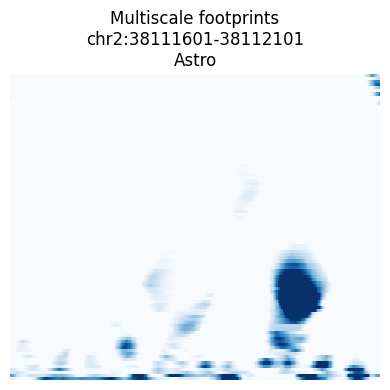

In [52]:
## test plots
%matplotlib inline
scp.pl.plot_footprints(
    printer_hydrop,
    save_key="500_footprints",
    group_names="Astro",
    region=convert_region_to_width("chr2:38111566-38112137",500),
    scales=None,
    ax=None,
    cmap="Blues",
    vmin=0.5,
    vmax=2.0,
)
scp.pl.plot_footprints(
    printer_10x,
    save_key="500_footprints",
    group_names="Astro",
    region=convert_region_to_width("chr2:38111566-38112137", 500),
    scales=None,
    ax=None,
    cmap="Blues",
    vmin=0.5,
    vmax=2.0,
)

In [67]:
%matplotlib inline
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

def compare_footprint_technologies(printer_10x, printer_hydrop, region_key, 
                                 cell_type_names=None, save_path=None, show=True):
    """
    Compare total footprint scores between two technologies for a given region.
    """
    # Extract footprint tensors for the region
    footprints_10x = printer_10x.footprintsadata["500_footprints"].obsm[region_key]  # (C, H, W)
    footprints_hydrop = printer_hydrop.footprintsadata["500_footprints"].obsm[region_key]  # (C, H, W)
    
    assert footprints_10x.shape == footprints_hydrop.shape, \
        f"Shape mismatch: 10x {footprints_10x.shape} vs Hydrop {footprints_hydrop.shape}"
    
    C, H, W = footprints_10x.shape
    
    # Sum across height and width dimensions to get total score per cell type
    total_scores_10x = np.sum(footprints_10x, axis=(1, 2))  # Shape: (C,)
    total_scores_hydrop = np.sum(footprints_hydrop, axis=(1, 2))  # Shape: (C,)
    
    if cell_type_names is None:
        cell_type_names = [f"Cell_Type_{i+1}" for i in range(C)]
    
    comparison_df = pd.DataFrame({
        'cell_type': cell_type_names[:C],  
        'total_score_10x': total_scores_10x,
        'total_score_hydrop': total_scores_hydrop,
        'region': region_key
    })
    
    # Calculate correlation
    correlation, p_value = pearsonr(total_scores_10x, total_scores_hydrop)
    
    if show:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(total_scores_10x, total_scores_hydrop, 
                            alpha=0.7, s=60, c=range(C))
        
        # Formatting
        plt.xlabel('10x Technology - Total Footprint Score', fontsize=12)
        plt.ylabel('Hydrop Technology - Total Footprint Score', fontsize=12)
        plt.title(f'Footprint Score Comparison: 10x vs Hydrop\nRegion: {region_key}\n'
                f'Correlation: r={correlation:.3f}, p={p_value:.2e}', fontsize=14)
        plt.grid(True, alpha=0.3)
        
        plt.axis('equal')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    return comparison_df

def compare_multiple_regions(printer_10x, printer_hydrop, region_keys, 
                           target_cell_types, cell_type_names, save_path=None):
    """
    Compare footprint scores across multiple regions.
    """
    
    assert len(region_keys) == len(target_cell_types), \
        "region_keys and target_cell_types must have the same length"

    all_comparisons = []
    
    for region_key, target_ct in zip(region_keys, target_cell_types):
        comparison_df = compare_footprint_technologies(
            printer_10x, printer_hydrop, region_key, 
            cell_type_names=cell_type_names, save_path=None, show=False
        )
        target_row = comparison_df[comparison_df['cell_type'] == target_ct]
        all_comparisons.append(target_row)
    combined_df = pd.concat(all_comparisons, ignore_index=True)

    plt.figure(figsize=(10, 10))
    
    plt.scatter(combined_df['total_score_hydrop'], combined_df['total_score_10x'], 
               alpha=0.8, s=60, c="#1f77b4")  # Plot all points at once, increased size for visibility
    
    overall_corr, overall_p = pearsonr(combined_df['total_score_10x'], 
                                      combined_df['total_score_hydrop'])
    
    overall_corr, overall_p = pearsonr(combined_df['total_score_10x'], 
                                      combined_df['total_score_hydrop'])
    
    # Add regression line
    z = np.polyfit(combined_df['total_score_hydrop'], combined_df["total_score_10x"], 1)
    p = np.poly1d(z)
    x_sorted = np.sort(combined_df['total_score_hydrop'])
    plt.plot(x_sorted, p(x_sorted), alpha=0.8, linewidth=1, c="black",
             label=f'r={overall_corr:.3f}')
    # Add text box with correlation info
    textstr = f'r = {overall_corr:.3f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.text(0.80, 0.20, textstr, transform=plt.gca().transAxes, fontsize=14,
             verticalalignment='top', bbox=props)

    plt.xlabel('HyDropv2', fontsize=12)
    plt.ylabel('10x', fontsize=12)
    plt.title(f'Footprint Score Comparison: 10x vs Hydrop (BICCN Enhancers)')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight', format="pdf")
    
    plt.show()
    
    return combined_df

2025-08-20 13:55:32 - INFO - maxp pruned
2025-08-20 13:55:32 - INFO - cmap pruned
2025-08-20 13:55:32 - INFO - kern dropped
2025-08-20 13:55:32 - INFO - post pruned
2025-08-20 13:55:32 - INFO - FFTM dropped
2025-08-20 13:55:32 - INFO - GPOS pruned
2025-08-20 13:55:32 - INFO - GSUB pruned
2025-08-20 13:55:32 - INFO - glyf pruned
2025-08-20 13:55:32 - INFO - Added gid0 to subset
2025-08-20 13:55:32 - INFO - Added first four glyphs to subset
2025-08-20 13:55:32 - INFO - Closing glyph list over 'MATH': 40 glyphs before
2025-08-20 13:55:32 - INFO - Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'N', 'S', 'a', 'c', 'colon', 'd', 'e', 'equal', 'five', 'h', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'v', 'x', 'y', 'zero']
2025-08-20 13:55:32 - INFO - Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 24, 26, 29, 32, 37, 38, 39, 40, 41, 43, 44, 49, 54, 68, 70, 71, 72, 75, 76, 

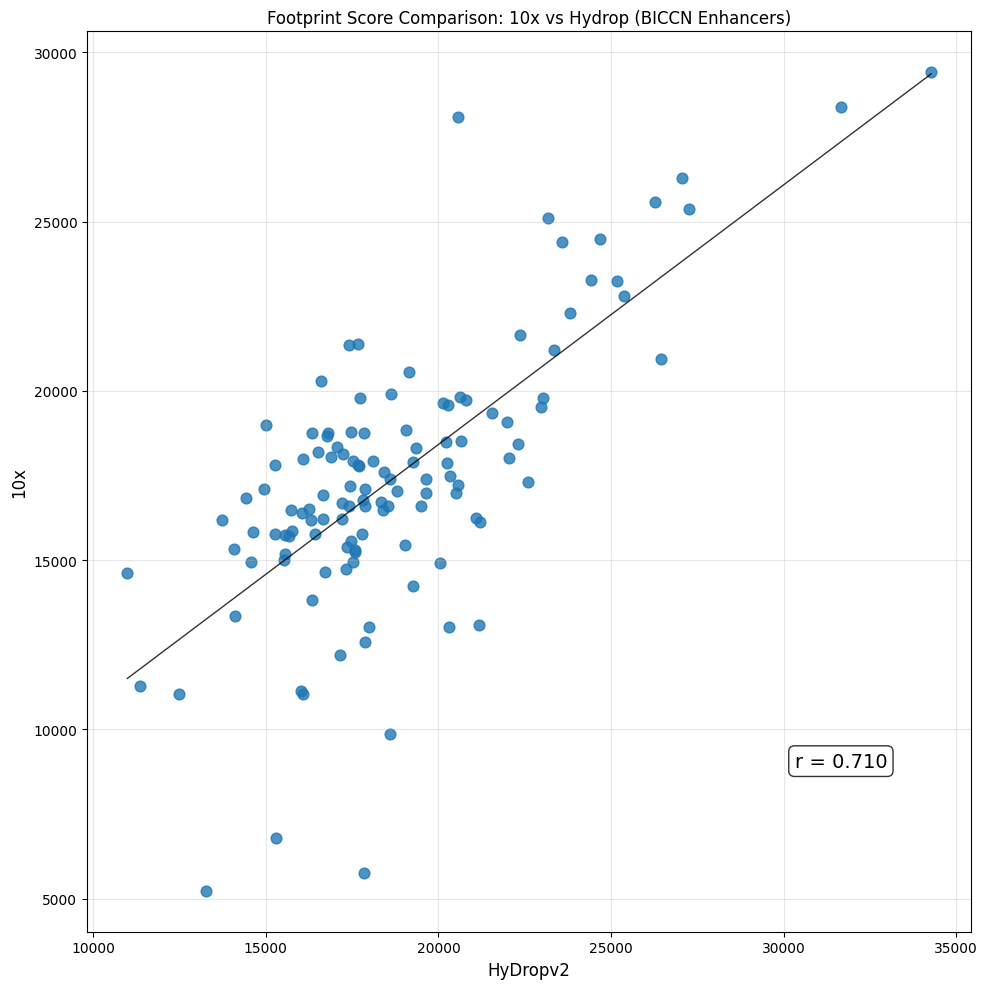

In [68]:
comp = compare_multiple_regions(
    printer_10x, 
    printer_hydrop, 
    region_keys=regions_of_interest_500, 
    target_cell_types=classes_of_interest,
    cell_type_names=list(group_names_10x),
    save_path="footprint_comparison_biccn_regions.pdf"
)

In [ ]:
# see which region has highest total_score_10x in comp
comp.sort_values(by="total_score_10x", ascending=False).head(10)

,cell_type,total_score_10x,total_score_hydrop,region
50,Astro,29408.987810,34275.768098,chr16:24325941-24326441
86,Oligo,28391.598601,31660.758836,chr4:72233618-72234118
77,L5_ET,28100.555969,20580.704375,chr3:110093856-110094356
64,Astro,26286.964569,27052.896169,chr2:38111601-38112101
19,L2_3_IT,25580.675261,26263.004791,chr12:63319522-63320022
108,Oligo,25380.625737,27263.507439,chr9:45854080-45854580
55,Astro,25109.535784,23166.433650,chr17:17409500-17410000
23,Astro,24493.822658,24693.831139,chr13:15543685-15544185
58,L5_IT,24385.879962,23583.766516,chr18:86704739-86705239
70,Oligo,23263.782795,24408.725196,chr2:121798950-121799450


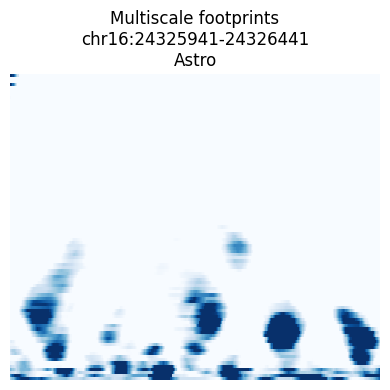

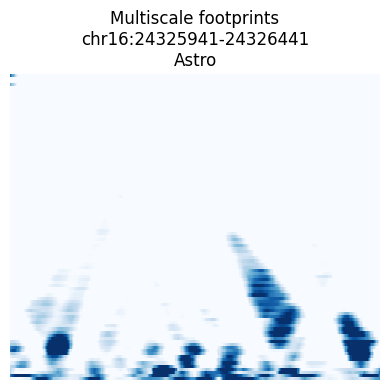

In [71]:
# plot that region
## test plots
%matplotlib inline
scp.pl.plot_footprints(
    printer_hydrop,
    save_key="500_footprints",
    group_names="Astro",
    region=convert_region_to_width("chr16:24325941-24326441",500),
    scales=None,
    ax=None,
    cmap="Blues",
    vmin=0.5,
    vmax=2.0,
)
scp.pl.plot_footprints(
    printer_10x,
    save_key="500_footprints",
    group_names="Astro",
    region=convert_region_to_width("chr16:24325941-24326441", 500),
    scales=None,
    ax=None,
    cmap="Blues",
    vmin=0.5,
    vmax=2.0,
)

In [76]:
printer_hydrop.close()
time.sleep(1)
printer_10x.close()
time.sleep(1)